In [2]:
!pip install -q transformers datasets evaluate segments-ai
!apt-get install git-lfs
!git lfs install
!huggingface-cli login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import os
import numpy as np
from PIL import Image
import cv2
#Capture training image info as a list


#original images must be in same order as masks in folder
train_images = []
imgPath ="/content/drive/MyDrive/Coral_Reef_Metadata/Annotated_Arrays/"
                                #path to training imgs
for directory_path in os.listdir(imgPath):
    arr = np.load(imgPath+directory_path)
    img = arr["image"]
    imgResized = cv2.resize(img, (224, 224))
    imgPIL = Image.fromarray(imgResized)
    train_images.append(imgPIL)


In [5]:
# #load dummy dataset, find shape
# from datasets import load_dataset
# ds = load_dataset("scene_parse_150")
# ds.shape
# ds.column_names
# ds['train']


<PIL.Image.Image image mode=L size=224x224 at 0x7F653F724790>


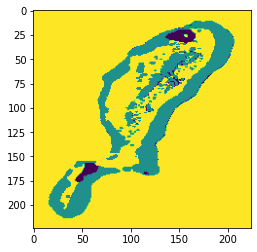

In [6]:
import cv2
from matplotlib import pyplot as plt

#Capture mask/label info as a list
train_masks = [] 
                                #path to respective masks
for directory_path in os.listdir(imgPath):
    arr = np.load(imgPath+directory_path)
    img = arr["label"] 

    vegetation, reef_flat, ocean = cv2.split(img)
    ocean = ocean * 2
    imgL = reef_flat + ocean
    imgResized = cv2.resize(imgL, (224, 224))
    imgPIL = Image.fromarray(imgResized)
    train_masks.append(imgPIL)

print(train_masks[0])
plt.imshow(train_masks[2])

In [7]:
# import dataset here as 'ds'
train_data = {'train':[], 'test':[], 'scene_category':[]}
one_dataframe = []
for i in range(len(train_images)):
  one_dataframe.append([train_images[i], train_masks[i]])

testSize = round(len(one_dataframe)*.2)
trainSize = len(one_dataframe) - testSize

import random
random.shuffle(one_dataframe)

train_images = []
train_masks = []
for i in range(trainSize):
  this_item = one_dataframe.pop()
  train_images.append(this_item[0])
  train_masks.append(this_item[1])

train_ds = {'pixel_values':train_images, 'label':train_masks}

test_images = []
test_masks = []
for i in range(testSize):
  this_item = one_dataframe.pop()
  test_images.append(this_item[0])
  test_masks.append(this_item[1])

test_ds = {'pixel_values':test_images, 'label':test_masks}

from datasets import Dataset
train_ds = Dataset.from_dict(train_ds)
test_ds = Dataset.from_dict(test_ds)

In [8]:
# #take 2: structure is a list of dicts, {'pixel_values':PIL_img, 'label':PIL_img}
# #makes one_dataframe in setup of structure needed
# one_dataframe = []
# for i in range(len(train_images)):
#   one_dataframe.append({'pixel_values':train_images[i], 'label':train_masks[i]})

# #shuffles
# import random
# random.shuffle(one_dataframe)

# #divides into train and test datasets
# #finds size of test/train sets
# testSize = round(len(one_dataframe)*.2)
# trainSize = len(one_dataframe) - testSize
# #initializes testdata and traindata lists
# testdata = []
# traindata = []

# #appends first bunch of shuffled data into test dataset
# for i in range(testSize):
#   this_item = one_dataframe.pop()
#   testdata.append(this_item)

# #same but for rest of data into train dataset
# for i in range(trainSize):
#   this_item = one_dataframe.pop()
#   traindata.append(this_item)

# #converts into actual Dataset object
# from datasets import Dataset
# train_ds = Dataset.from_dict(traindata)
# test_ds = Dataset.from_dict(testdata)

In [9]:
#splits dataset into train and test datasets
# ds = ds.shuffle(seed=1)
# ds = ds["train"].train_test_split(test_size=0.2)
# train_ds = ds["train"]
# test_ds = ds["test"]

In [10]:
#extracts number of labels
#actually we prob need to upload our data to huggingface first which is annoying but it be like that
id2label = {0:'vegetation', 1:'reef flats', 2:'ocean'}
label2id = {'vegetation':0, 'reef flats':1, 'ocean':2}
num_labels = 3

In [11]:
from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor

#transforms data to be the shape expected by huggingface
#also uses colorjitter to randomly change stuff around and augment dataset
feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

#transforms training data as needed
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs

#transforms evaluation data as needed
def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

/usr/local/lib/python3.8/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [12]:
from transformers import SegformerForSemanticSegmentation

#imports pretrained model we're going to be yoinking from 
#b0 is smallest model, easiest to use for now
pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.

In [13]:
from transformers import TrainingArguments

#hyperparams for training
epochs = 20
lr = 0.00006
batch_size = 2

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=False,
    hub_strategy="end",
)

In [14]:
import torch
from torch import nn
import evaluate

#creates file for training metrics
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=255,
            reduce_labels=feature_extractor.reduce_labels,
        )
    
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
    
    return metrics

In [15]:
from transformers import Trainer

#creates training obj for training model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)


In [16]:
#does the thing
trainer.train()
print(compute_metrics)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 54
  Num Epochs = 20
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 540
  Number of trainable parameters = 3714915


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Vegetation,Accuracy Reef flats,Accuracy Ocean,Iou Vegetation,Iou Reef flats,Iou Ocean
20,0.649200,0.835903,0.553354,0.708132,0.832564,0.320957,0.971615,0.831823,0.313470,0.520370,0.826221
40,0.507800,0.556323,0.754762,0.840843,0.930476,0.687916,0.875007,0.959604,0.622950,0.706126,0.935210
60,0.489100,0.462270,0.803627,0.903395,0.938152,0.839513,0.922306,0.948367,0.732583,0.741313,0.936985
80,0.324100,0.402573,0.815899,0.911586,0.947553,0.929988,0.826747,0.978023,0.744006,0.752862,0.950830
100,0.357500,0.318017,0.838327,0.909543,0.949882,0.864324,0.895754,0.968550,0.795875,0.769754,0.949353
120,0.333500,0.291675,0.843334,0.913051,0.950935,0.879511,0.889074,0.970569,0.807811,0.772204,0.949988
140,0.212300,0.244797,0.847813,0.909066,0.953488,0.897324,0.846868,0.983005,0.816741,0.773685,0.953013
160,0.234200,0.210359,0.852558,0.911968,0.955012,0.914531,0.834477,0.986896,0.826112,0.777097,0.954466
180,0.266300,0.190287,0.856687,0.914375,0.956133,0.913537,0.843305,0.986282,0.831511,0.783161,0.955390
200,0.224700,0.201424,0.857352,0.911821,0.956235,0.903251,0.845718,0.986493,0.832900,0.783788,0.955369


***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
/usr/local/lib/python3.8/dist-packages/transformers/models/segformer/image_processing_segformer.py:124: FutureWarning: The `reduce_labels` property is deprecated and will be removed in a v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(
Saving model checkpoint to segformer-b0-finetuned-segments-sidewalk-outputs/checkpoint-20
Configuration saved in segformer-b0-finetuned-segments-sidewalk-outputs/checkpoint-20/config.json
Model weights saved in segformer-b0-finetuned-segments-sidewalk-outputs/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
/usr/local/lib/python3.8/dist-packages/transformers/models/segformer/image_processing_segformer.py:124: FutureWarning: The `reduce_labels` property is deprecated and will be removed in a v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(
Saving model checkpoint to segformer-b0-finetuned-segments-sidewalk-outp

<function compute_metrics at 0x7f6444cca790>


In [28]:
image = test_ds[5]['pixel_values']
gt_seg = test_ds[5]['labels']

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


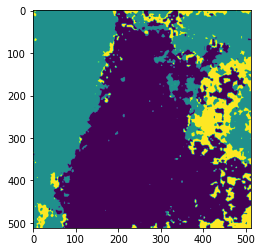

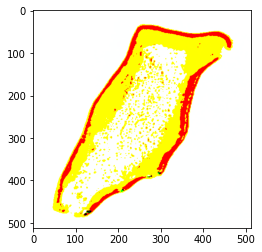

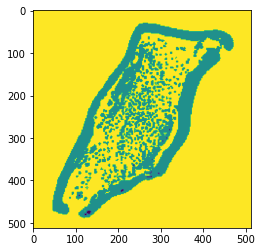

In [30]:
from torch import nn
from matplotlib import pyplot as plt

inputs = feature_extractor(images=image, return_tensors="pt")
inputs = inputs.to(device='cuda')
%time
outputs = model(**inputs)
shape = image[::-1].shape
endSize = (shape[1],shape[2])
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=endSize, # (height, width)
    mode='bilinear'
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]
outputTensor = pred_seg.to('cpu')
outputNPArray = outputTensor.numpy()

thing = plt.imshow(outputNPArray)
plt.show()

im = np.swapaxes(image, 0,2)
im = np.swapaxes(im, 0, 1)
plt.imshow(im.astype(np.uint8), cmap = "viridis")
plt.show()

im2 = gt_seg
plt.imshow(im2, cmap = 'viridis')
plt.show()

In [19]:
trainer.save_model("drive/MyDrive/Coral_Reef_Metadata")

Saving model checkpoint to drive/MyDrive/Coral_Reef_Metadata
Configuration saved in drive/MyDrive/Coral_Reef_Metadata/config.json
Model weights saved in drive/MyDrive/Coral_Reef_Metadata/pytorch_model.bin
